### Cas Brillouin 

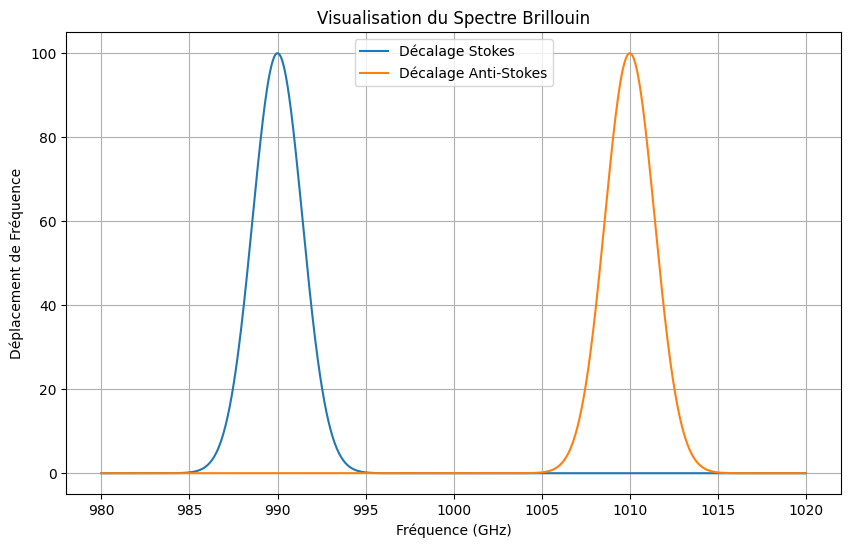

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Paramètres du spectre Brillouin simplifié
nombre_exemples = 100
frequence_incidente = 1000  # Fréquence de la lumière incidente en GHz
deplacement_phonon = 10  # Déplacement de fréquence associé aux phonons en GHz
largeur_pic = 2  # Largeur du pic Brillouin en GHz
intensite_pic = 100  # Intensité du pic Brillouin

# Générer des données pour le spectre Brillouin et les enregistrer dans un fichier CSV
for i in range(nombre_exemples):
    frequences = np.linspace(frequence_incidente - 20, frequence_incidente + 20, 1000)
    deplacement_stokes = intensite_pic * np.exp(-((frequences - (frequence_incidente - deplacement_phonon)) / largeur_pic)**2)
    deplacement_anti_stokes = intensite_pic * np.exp(-((frequences - (frequence_incidente + deplacement_phonon)) / largeur_pic)**2)

    # Créer un DataFrame pandas
    df = pd.DataFrame({'Frequence': frequences, 'Deplacement_Stokes': deplacement_stokes, 'Deplacement_Anti_Stokes': deplacement_anti_stokes})

    # Enregistrer dans un fichier CSV
    df.to_csv(f'brillouin_example_{i + 1}.csv', index=False)

# Créer la visualisation du spectre Brillouin
plt.figure(figsize=(10, 6))
plt.plot(frequences, deplacement_stokes, label='Décalage Stokes')
plt.plot(frequences, deplacement_anti_stokes, label='Décalage Anti-Stokes')
plt.title('Visualisation du Spectre Brillouin')
plt.xlabel('Fréquence (GHz)')
plt.ylabel('Déplacement de Fréquence')
plt.legend()
plt.grid(True)
plt.show()


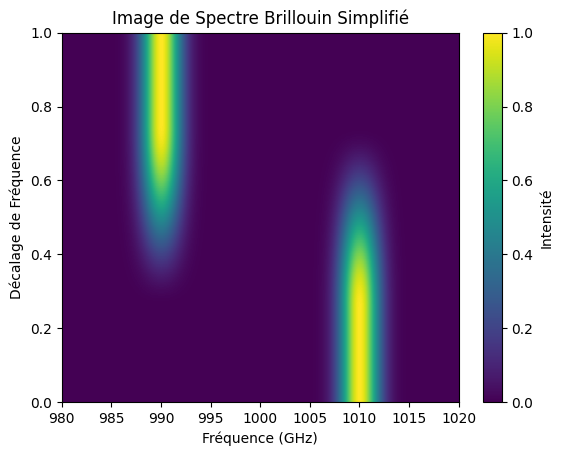

In [21]:

# Créer une matrice d'image
image_matrix = np.vstack((deplacement_stokes, deplacement_anti_stokes))

# Normaliser les valeurs pour les couleurs (facultatif)
image_matrix = image_matrix / np.max(image_matrix)

# Créer l'image avec une colormap personnalisée
plt.imshow(image_matrix, cmap='viridis', aspect='auto', extent=[min(frequences), max(frequences), 0, 1])
plt.title('Image de Spectre Brillouin Simplifié')
plt.xlabel('Fréquence (GHz)')
plt.ylabel('Décalage de Fréquence')
plt.colorbar(label='Intensité')
plt.show()

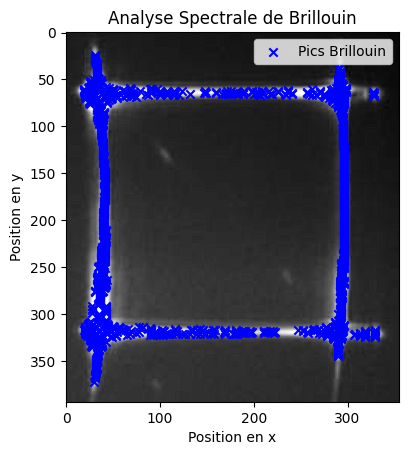

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Charger l'image
image_path = 'data.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Détection des pics
peaks, _ = find_peaks(image.flatten(), height=210)  # Réglez le seuil selon votre image

# Mesure des caractéristiques des pics
positions_pics = np.unravel_index(peaks, image.shape)

# Afficher l'image avec les pics détectés
plt.imshow(image, cmap='gray')
plt.scatter(positions_pics[1], positions_pics[0], c='blue', marker='x', label='Pics Brillouin')
plt.title('Analyse Spectrale de Brillouin')
plt.xlabel('Position en x')
plt.ylabel('Position en y')
plt.legend()
plt.show()


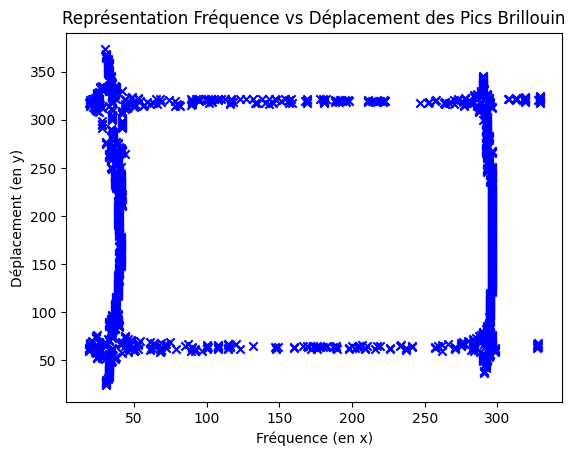

In [23]:
plt.scatter(positions_pics[1], positions_pics[0], c='blue', marker='x')
plt.title('Représentation Fréquence vs Déplacement des Pics Brillouin')
plt.xlabel('Fréquence (en x)')
plt.ylabel('Déplacement (en y)')
plt.show()


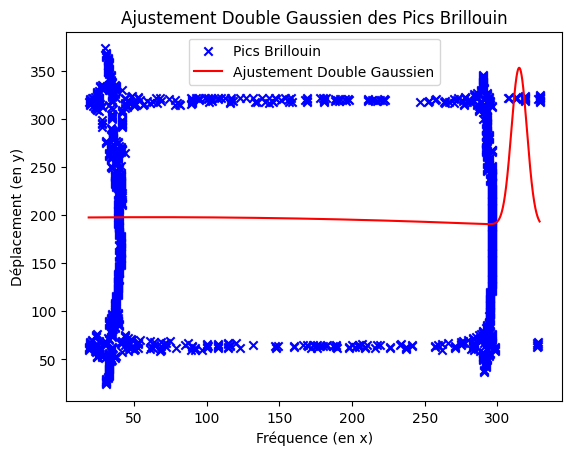

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Données des pics Brillouin (fréquence en x, déplacement en y)
x_data = positions_pics[1]
y_data = positions_pics[0]

# Définir une fonction gaussienne avec deux termes gaussiens
def double_gaussienne(x, A1, mu1, sigma1, A2, mu2, sigma2):
    return A1 * np.exp(-(x - mu1)**2 / (2 * sigma1**2)) + A2 * np.exp(-(x - mu2)**2 / (2 * sigma2**2))

# Ajuster la double gaussienne aux données
# Utilisez p0 pour fournir des estimations initiales des paramètres
parametres_optimaux, _ = curve_fit(double_gaussienne, x_data, y_data, p0=[190, 50, 160, 210, 300, 10])

# Générer des données pour la courbe ajustée
x_fit = np.linspace(min(x_data), max(x_data), 10000)
y_fit = double_gaussienne(x_fit, *parametres_optimaux)

# Afficher les points et la courbe ajustée
plt.scatter(x_data, y_data, c='blue', marker='x', label='Pics Brillouin')
plt.plot(x_fit, y_fit, 'r-', label='Ajustement Double Gaussien')
plt.title('Ajustement Double Gaussien des Pics Brillouin')
plt.xlabel('Fréquence (en x)')
plt.ylabel('Déplacement (en y)')
plt.legend()
plt.show()


In [16]:
import cv2
import numpy as np
from scipy.optimize import curve_fit

# Charger l'image (à remplacer par votre propre chemin d'image)
image_path = 'data.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
nominal_fsr = 2  # Remplacez la valeur par la FSR réelle de votre spectromètre


# Étape 1: Amélioration de la visualisation
def enhance_visualization(image):
    # Conversion en fausses couleurs
    enhanced_image = cv2.applyColorMap(image, cv2.COLORMAP_JET)
    # Normalisation par l'écart type
    enhanced_image = (enhanced_image - np.mean(enhanced_image)) / np.std(enhanced_image)
    return enhanced_image

# Étape 2: Identification des Pics Rayleigh
def identify_rayleigh_peaks(image):
    # Convertir l'image binaire en 8 bits
    binary_image_8bit = cv2.convertScaleAbs(image)

    # Convertir l'image binaire en niveaux de gris
    gray_image = cv2.cvtColor(binary_image_8bit, cv2.COLOR_BGR2GRAY)

    # Identifier les pics Rayleigh (exemple avec des coins de l'image)
    corners = cv2.goodFeaturesToTrack(gray_image, maxCorners=4, qualityLevel=0.01, minDistance=10)
    return corners.reshape(-1, 2)


# Étape 3: Correction par Homographie
def apply_homography_correction(image, homography_matrix):
    # Appliquer la matrice d'homographie à l'image
    corrected_image = cv2.warpPerspective(image, homography_matrix, (image.shape[1], image.shape[0]))
    return corrected_image

# Étape 4: Extraction des Spectres Brillouin
def extract_brillouin_spectra(image):
    # Recadrer et pivoter l'image (exemple avec des coins de l'image)
    cropped_image = image[100:400, 100:400]

    # Extraire les spectres (exemple avec une moyenne par colonne)
    brillouin_spectra = np.max(cropped_image, axis=0)
    return brillouin_spectra

# Étape 5: Conversion de l'Axe de Dispersion
def convert_dispersion_axis(frequency_scale, nominal_fsr):
    # Convertir l'axe de dispersion (exemple avec une simple échelle linéaire)
    converted_axis = np.linspace(0, nominal_fsr, len(frequency_scale))
    return converted_axis

# Étape 6: Analyse des Pics Brillouin
def analyze_brillouin_peaks(data):
    # Séparer les données du bruit de fond (exemple avec une simple comparaison)
    signal_threshold = 0.7 * np.max(data)
    background_data = data[data < signal_threshold]

    # Ajustements de courbe (exemple avec une fonction simple)
    def lorentzian(x, A, mu, sigma):
        return A / (1 + ((x - mu) / sigma)**2)

    popt, _ = curve_fit(lorentzian, converted_axis, data)

    return background_data, popt

# Appliquer les différentes étapes
enhanced_image = enhance_visualization(image)
rayleigh_peaks = identify_rayleigh_peaks(enhanced_image)

# Calculer la matrice d'homographie (exemple avec une matrice identité)
homography_matrix = np.eye(3)

corrected_image = apply_homography_correction(enhanced_image, homography_matrix)
brillouin_spectra = extract_brillouin_spectra(corrected_image)
converted_axis = convert_dispersion_axis(brillouin_spectra, nominal_fsr)
# background_data, fit_parameters = analyze_brillouin_peaks(brillouin_spectra)

# Affichage ou traitement supplémentaire en fonction de vos besoins


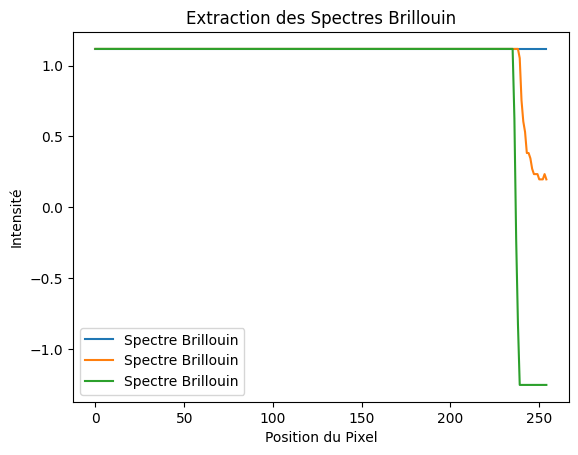

In [17]:
import matplotlib.pyplot as plt

def plot_brillouin_spectra(brillouin_spectra):
    plt.plot(brillouin_spectra, label='Spectre Brillouin')
    plt.title('Extraction des Spectres Brillouin')
    plt.xlabel('Position du Pixel')
    plt.ylabel('Intensité')
    plt.legend()
    plt.show()

# Utilisation de la fonction
plot_brillouin_spectra(brillouin_spectra)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


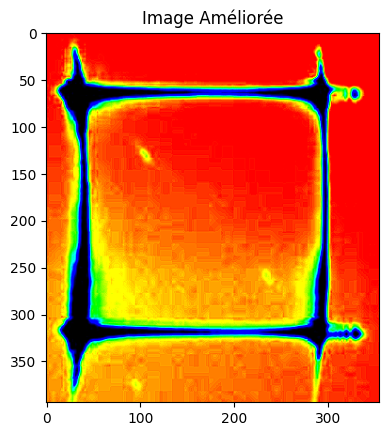

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


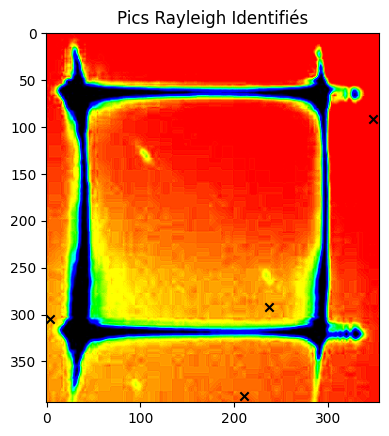

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


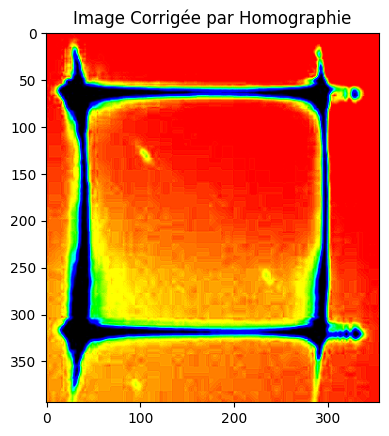

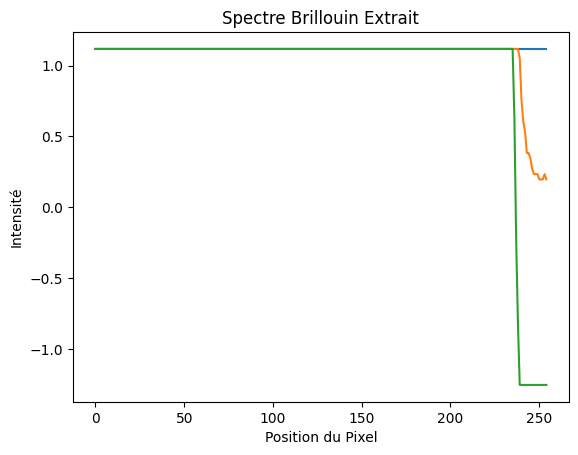

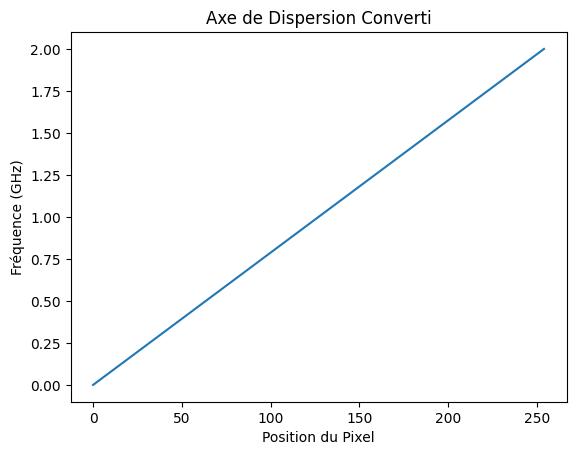

In [46]:
# Visualisation de l'image améliorée
plt.imshow(enhanced_image)
plt.title('Image Améliorée')
plt.show()

# Visualisation des pics Rayleigh identifiés
plt.imshow(enhanced_image)
plt.scatter(rayleigh_peaks[:, 0], rayleigh_peaks[:, 1], c='black', marker='x')
plt.title('Pics Rayleigh Identifiés')
plt.show()

# Visualisation de l'image corrigée par homographie
plt.imshow(corrected_image)
plt.title('Image Corrigée par Homographie')
plt.show()

# Visualisation du spectre Brillouin extrait
plt.plot(brillouin_spectra)
plt.title('Spectre Brillouin Extrait')
plt.xlabel('Position du Pixel')
plt.ylabel('Intensité')
plt.show()

# Visualisation de l'axe de dispersion converti
plt.plot(converted_axis)
plt.title('Axe de Dispersion Converti')
plt.xlabel('Position du Pixel')
plt.ylabel('Fréquence (GHz)')
plt.show()


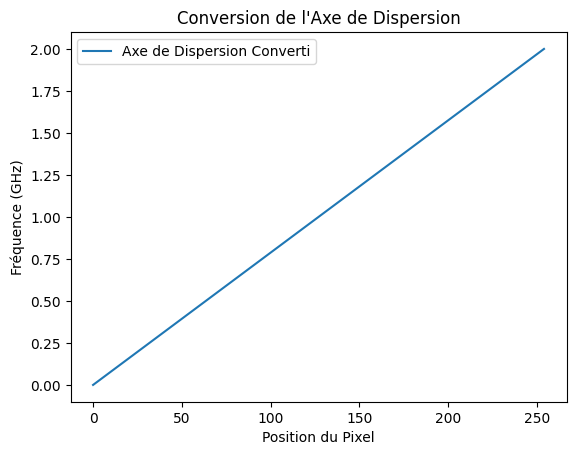

In [18]:
def plot_dispersion_axis(converted_axis):
    plt.plot(converted_axis, label='Axe de Dispersion Converti')
    plt.title('Conversion de l\'Axe de Dispersion')
    plt.xlabel('Position du Pixel')
    plt.ylabel('Fréquence (GHz)')
    plt.legend()
    plt.show()

# Utilisation de la fonction
plot_dispersion_axis(converted_axis)
